In [1]:
import requests
from time import sleep
from lxml import html
import numpy as np
import pandas as pd
from itertools import groupby

In [2]:
#парсим адреса Burger King
def get_address(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36'}
    r = requests.get(url, headers = headers)
    tree = html.fromstring(r.content)
    return tree.xpath("//a/div[2]/span/text()")

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

In [4]:
#парсим адреса KFC
address_kfc=[]
co = Options()
co.add_argument("--start-maximized")
#co.add_argument('--headless')
driver = webdriver.Chrome(chrome_options=co)
driver.get('https://www.kfc.ru/restaurants')
driver.find_element_by_xpath("//input[@placeholder='Найти ...']").send_keys('Москва')
sleep(2)
driver.find_element_by_xpath("//button[contains(.,'Список')]").click()
sleep(2)
addresss_kfc=driver.find_elements_by_xpath("//div[@class='_2XllDYbBnt t-m-sm mt-8']")
for addres_kfc in addresss_kfc:
    address_kfc.append(addres_kfc.text)
driver.quit()

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


In [5]:
len(address_kfc)

327

In [6]:

url_brk = 'https://www.spr.ru/moskva/branches/burger-king/'
address_brk=get_address(url_brk)

In [7]:
#убираем из списка адрес Москва без улицы
address_brk = address_brk[1:-1]
print(len(address_brk))

135


In [8]:
#Убираем дубликаты 
address_brk = [x for x, _ in groupby(address_brk)]
print(len(address_brk))

128


In [9]:
address_kfc = [x for x, _ in groupby(address_kfc)]
print(len(address_kfc))

325


In [21]:
#Функция получения координат по адресу
def get_coord(address):
    ya_keys=open('ya_key.token', 'r', encoding='utf-8')
    ya_key=ya_keys.read()
    ya_keys.close()
    kol_add=len(address)
    coord_list=[]
    for i in range(0, kol_add):
        url_map='https://geocode-maps.yandex.ru/1.x/?format=json&apikey='+ya_key+'&geocode='+address[i]+'&kind=district'
        r=requests.get(url_map).json()
        r_loc=r['response']['GeoObjectCollection']['featureMember']
        kol_seach=len(r['response']['GeoObjectCollection']['featureMember'])
        try:
            coord1=str(r_loc[0]['GeoObject']['Point']['pos']).split()[0]
            coord2=str(r_loc[0]['GeoObject']['Point']['pos']).split()[1]
            coord_list.append(str(coord1 + ',' + coord2))
        except IndexError:
            address_kfc.remove(address[i])
            i-=1
    return coord_list


In [11]:
coord_list_brk=get_coord(address_brk)

In [22]:
coord_list_kfc=get_coord(address_kfc)

In [23]:
#Создаем датафреймы
dataframe_brk=pd.DataFrame()
dataframe_kfc=pd.DataFrame()

In [24]:
dataframe_brk['address_brk']=address_brk
dataframe_brk['coords']=coord_list_brk
dataframe_kfc['address_kfc']=address_kfc
dataframe_kfc['coords']=coord_list_kfc

In [25]:
dataframe_brk.head()

,address_brk,coords
0,"Москва, Новочерёмушкинская ул., 1","37.589033,55.690359"
1,"Москва, Мира просп., 114-Б, стр. 2","37.638,55.808225"
2,"Москва, Воздвиженка ул., 9, стр. 2","37.603846,55.752642"
3,"Москва, Новый Арбат ул., 17","37.590713,55.752141"
4,"Москва, Ленинградский просп., 62-А","37.532098,55.801835"


In [26]:
#Функция получения растояния между двумя точками
import math
def get_S(llat1, llong1, llat2, llong2):
    
    #pi - число pi, rad - радиус сферы (Земли)
    rad = 6372795

    #в радианах
    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.

    #косинусы и синусы широт и разницы долгот
    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    #вычисления длины большого круга
    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)
    dist = ad*rad

    return round(dist/1000)
    

In [27]:
#Получаем список кол-ва ресторанов KFC в радиусе 2км от заданного ресторана Burger King
kol_kfc_list=[]
for i in range(0, len(dataframe_brk)):
    kol_kfc=0
    for j in range(0, len(dataframe_kfc)):
        llat1=float(dataframe_brk.coords[i].split(',')[1])
        llong1=float(dataframe_brk.coords[i].split(',')[0])
        llat2=float(dataframe_kfc.coords[j].split(',')[1])
        llong2=float(dataframe_kfc.coords[j].split(',')[0])
        distance=get_S(llat1, llong1, llat2, llong2)
        #print(distance)
        if distance <=2:
            kol_kfc+=1
    kol_kfc_list.append(kol_kfc)


In [28]:
dataframe_brk['kol_kfc_nearby']=kol_kfc_list

In [29]:
dataframe_brk.head(10)

,address_brk,coords,kol_kfc_nearby
0,"Москва, Новочерёмушкинская ул., 1","37.589033,55.690359",7
1,"Москва, Мира просп., 114-Б, стр. 2","37.638,55.808225",6
2,"Москва, Воздвиженка ул., 9, стр. 2","37.603846,55.752642",14
3,"Москва, Новый Арбат ул., 17","37.590713,55.752141",13
4,"Москва, Ленинградский просп., 62-А","37.532098,55.801835",6
5,"Москва, Енисейская ул., 19, к. 1","37.663018,55.869208",3
6,"Москва, Бауманская ул., 32, стр. 2","37.678325,55.772163",9
7,"Москва, Земляной Вал площадь, 33","37.656092,55.764187",14
8,"Москва, Земляной Вал ул., 26, стр. 1","37.657152,55.758114",14
9,"Москва, Бесединское шоссе, 15","37.76133,55.625282",3


In [30]:
#Сортируем по убыванию кол-во конкурентов
dataframe_brk.sort_values(by=['kol_kfc_nearby'], ascending=False)[0:10]

,address_brk,coords,kol_kfc_nearby
29,"Москва, Мясницкая ул., 9/11","37.63217,55.761406",19
50,"Москва, Театральный пр., 5","37.624651,55.760195",16
94,"Москва, Цветной бульв., 13","37.620016,55.770578",16
2,"Москва, Воздвиженка ул., 9, стр. 2","37.603846,55.752642",14
93,"Москва, Манежная площадь, 1, стр. 2","37.614608,55.755773",14
7,"Москва, Земляной Вал площадь, 33","37.656092,55.764187",14
8,"Москва, Земляной Вал ул., 26, стр. 1","37.657152,55.758114",14
69,"Москва, Садовая-Кудринская ул., 3-А","37.584559,55.760099",13
3,"Москва, Новый Арбат ул., 17","37.590713,55.752141",13
92,"Москва, Лесная ул., 5","37.586877,55.777783",12


In [31]:
#Назначаем каждому значению кол-ва конкурентов свой случайный цвет
import randomcolor
rand_color = randomcolor.RandomColor()
dic_colors = {a: rand_color.generate()[0] for a in dataframe_brk['kol_kfc_nearby'].value_counts().index}

In [32]:
dic_colors

{4: '#e8bb94',
 3: '#3faff4',
 6: '#bfea75',
 2: '#078422',
 1: '#f814fc',
 5: '#d66292',
 7: '#b294f7',
 9: '#d608b3',
 8: '#19005e',
 0: '#97e557',
 14: '#f2d5a4',
 10: '#f95ecb',
 16: '#ecb0f4',
 11: '#3342b7',
 13: '#95b7e5',
 12: '#72ff8a',
 19: '#b74cdb'}

In [33]:
color_list=[]
for kol_num in dataframe_brk['kol_kfc_nearby'].array:
    color_list.append(dic_colors[kol_num])

In [34]:
dataframe_brk['marker-color']=color_list

In [35]:
#Меняем название колонок для иморта в констуктор яндекс карт
dataframe_brk.rename(columns={'address_brk': 'iconCaption', 'kol_kfc_nearby': 'description', }, inplace=True)

In [36]:
dataframe_brk.head()

,iconCaption,coords,description,marker-color
0,"Москва, Новочерёмушкинская ул., 1","37.589033,55.690359",7,#b294f7
1,"Москва, Мира просп., 114-Б, стр. 2","37.638,55.808225",6,#bfea75
2,"Москва, Воздвиженка ул., 9, стр. 2","37.603846,55.752642",14,#f2d5a4
3,"Москва, Новый Арбат ул., 17","37.590713,55.752141",13,#95b7e5
4,"Москва, Ленинградский просп., 62-А","37.532098,55.801835",6,#bfea75


In [37]:
#Получаем структуру geojson
def df_to_geojson(df, properties, coord='coords'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'geometry':{'type':'Point',
                               'coordinates':[]},
                    'properties':{}}
        feature['geometry']['coordinates'] = [(row[coord]).split(',')[0],(row[coord]).split(',')[1]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    
    return geojson

In [38]:
useful_columns = ['iconCaption', 'description', 'marker-color']
geojson_dict = df_to_geojson(dataframe_brk, properties=useful_columns)
geojson_str = json.dumps(geojson_dict, indent=2, ensure_ascii=False)

In [39]:
output_filename = 'dataset.geojson'
with open(output_filename, 'w', encoding='utf-8') as output_file:
    output_file.write('{}'.format(geojson_str))
    
print('{} геотега сохранены в файл'.format(len(geojson_dict['features'])))

128 геотега сохранены в файл


После импортируем dataset.geojson в Конструктор карт Яндекса https://yandex.ru/map-constructor/ и получаем метки на карте

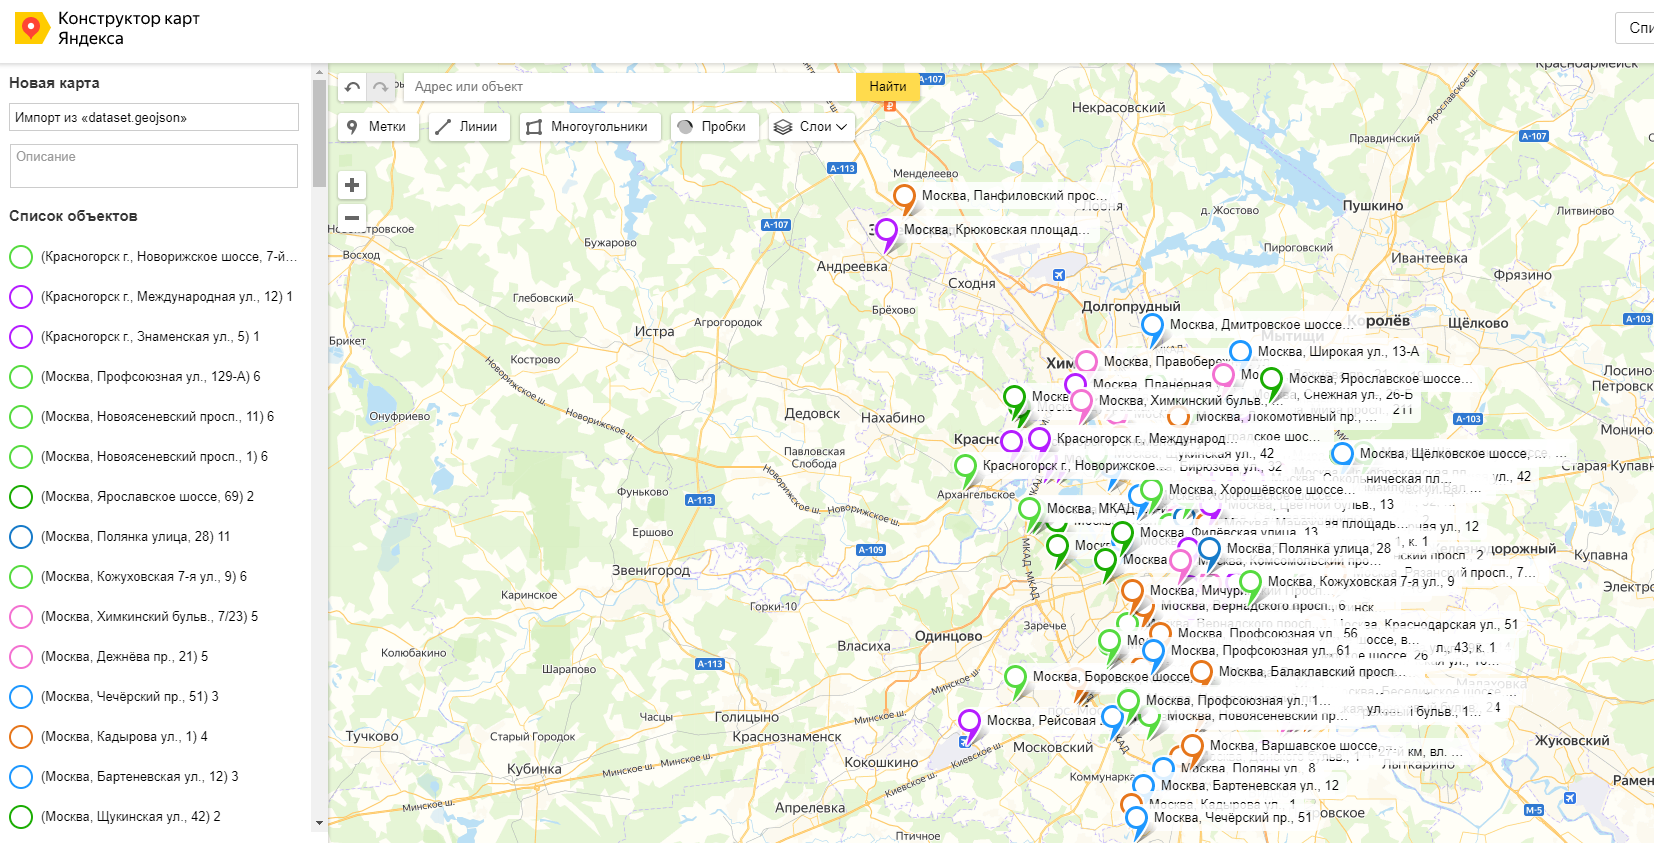